In [1]:
import pandas as pd
import numpy as np
import seaborn as sns; sns.set_style("darkgrid")
from sklearn import linear_model
import random
import math
import os

import warnings
warnings.filterwarnings('ignore')


/usr/lib/python3/dist-packages/matplotlib/__init__.py:874: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


Decripcion de los datos
             year        temp
count   133.00000  133.000000
mean   1946.00000    8.528271
std      38.53786    0.629293
min    1880.00000    6.920000
25%    1913.00000    8.100000
50%    1946.00000    8.430000
75%    1979.00000    8.890000
max    2012.00000   10.410000

Las primeras 8 filas de los datdos
   year  temp
0  1880  7.79
1  1881  8.19
2  1882  8.49
3  1883  7.94
4  1884  7.60
5  1885  8.16
6  1886  7.67
7  1887  8.23


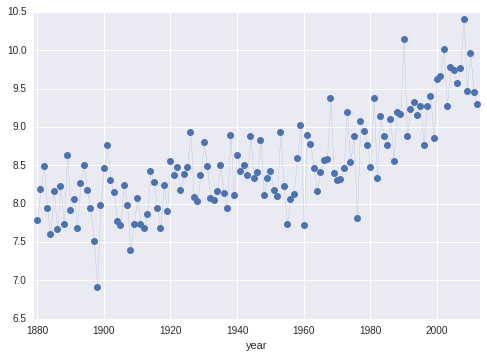

In [35]:
# Levanto los datos
df = pd.read_csv('./data/worldTemperature.csv', ' ', header = None, names = (['year', 'temp']))
print("Decripcion de los datos")
print(df.describe())

print("\nLas primeras 8 filas de los datdos")
print(df.head(8))

# Graficos los datos
ax = sns.tsplot(time=df['year'], data=df['temp'], interpolate=False)
sns.plt.show()

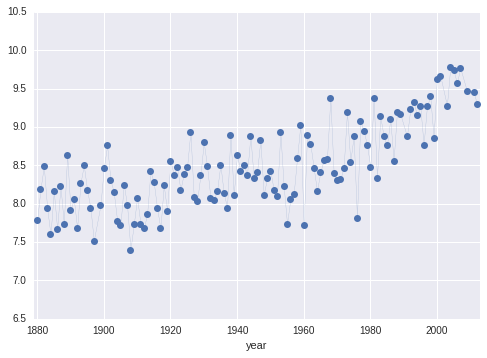

In [36]:
# Limpio los outliers
def mascara_outliers(s):
    return abs(s - s.mean()) <= 2*s.std()
    
mascara = mascara_outliers(df['temp'])
df = df[mascara]
sns.tsplot(time=df['year'], data=df['temp'], interpolate=False)

# Para que se evidencien mejor los outliers que saque, grafico en el mismo rango
# Algunos me parecen que no deberian ser removidos
sns.plt.ylim((6.5, 10.5))
sns.plt.show()

In [43]:
# Uso cuadrados minimos para predecir
sns.tsplot(time=df['year'], data=df['temp'], interpolate=False)

def armar_matriz_A(s):
    temp = []
    for t in s:
        temp.append([20*np.cos(5*t),1000*np.cos(60*t),10*np.sin(50*t),t, 1])
    return np.array(temp)

def entrenar_y_predecir_en_rangos(df, rango_entrenamiento, rango_prediccion):
    regr = linear_model.LinearRegression(fit_intercept=False)
    ECM = []
    # Entreno el modelo
    df_e = df[df['year'].isin(rango_entrenamiento)]
    A_e = armar_matriz_A(df_e['year'])
    regr.fit(A_e, df_e['temp'])

    # Me fijo la aproximacion que se realizo
    df_e['p'] = regr.predict(A_e)
    sns.tsplot(time=df_e['year'], data=df_e['p'], color='r')
    
    ECM.append(sum((df_e['p']-df_e['temp'])**2)/len(rango_prediccion))
    # Realizo predicciones
    df_p = df[df['year'].isin(rango_prediccion)]

    A_p = armar_matriz_A(df_p['year'])
    df_p['p'] = regr.predict(A_p)
    sns.tsplot(time=df_p['year'], data=df_p['p'], color='g')

    ECM.append(sum((df_p['p']-df_p['temp'])**2)/len(rango_prediccion))
    return ECM

def entrenar_y_pronosticar(df, rango_entrenamiento, rango_prediccion):
    regr = linear_model.LinearRegression(fit_intercept=False)
    ECM = []
    # Entreno el modelo
    df_e = df[df['year'].isin(rango_entrenamiento)]
    A_e = armar_matriz_A(df_e['year'])
    regr.fit(A_e, df_e['temp'])

    # Me fijo la aproximacion que se realizo
    df_e['p'] = regr.predict(A_e)
    sns.tsplot(time=df_e['year'], data=df_e['p'], color='r')
    
    # Realizo predicciones

    A_p = armar_matriz_A(rango_prediccion)
    df_p = regr.predict(A_p)
    sns.tsplot(time=rango_prediccion, data=df_p, color='g')

    return 

def predecir(k):
    return entrenar_y_predecir_en_rangos(df, range(k-35,k), range(k,k+10))

def pronosticar(k):
    return entrenar_y_pronosticar(df, range(k-35,k), range(k,k+10))



[0.30244064973738771, 0.075510665521651421]
[0.24042748017946952, 0.15444984528848216]
[0.26124537470809572, 0.077559396891206292]
[0.21156732808132009, 0.18632763476490971]
[0.24552826719049783, 0.19621921112165147]
[0.37623139958637364, 0.1269540036998163]
[0.38144382161611179, 0.21496805810408834]
[0.39443885489899894, 0.035141311951824766]
[0.29752776252604002, 0.1341329031953169]
Error promedio de entrenamiento:0.301
Error promedio de prediccion:0.133


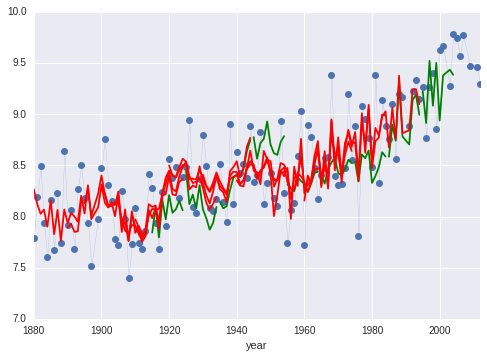

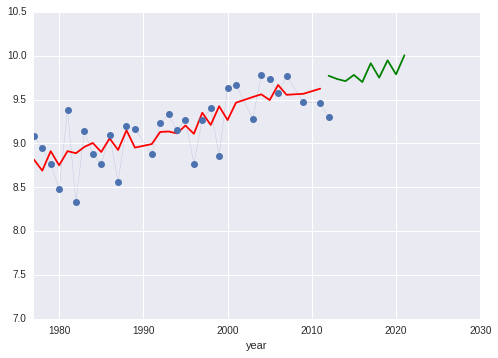

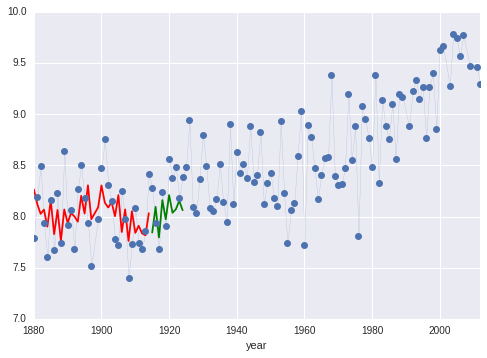

In [44]:
#Varios casos de entrenamiento
er_train = []
er_pred = []

for year in range(1915,2005,10):
    ECM = predecir(year)
    print(ECM)
    er_train.append(ECM[0])
    er_pred.append(ECM[1])


print("Error promedio de entrenamiento:{:.3f}".format(np.array(er_train).mean()))
print("Error promedio de prediccion:{:.3f}".format(np.array(er_pred).mean()))
sns.plt.xlim((1880, 2012))
sns.plt.show()


#Grafico pronostico a futuro
pronosticar(2012)
sns.tsplot(time=df['year'], data=df['temp'], interpolate=False)
sns.plt.xlim((2012-35, 2030))
sns.plt.show()

#Elegir uno de los graficos en algun intervalo y mostrarlo en el informe, por ejemplo:
predecir(1915)
sns.tsplot(time=df['year'], data=df['temp'], interpolate=False)
sns.plt.xlim((1880, 2012))
sns.plt.show()






In [227]:
#Experimento 2:

In [175]:
#Funciones de entrenamiento y creación de la matriz adaptadas a experimentos multivariados

#S es una matriz. Cada fila contiene X_i grande(un vector de temperaturas por pais para un año determinado)
def armar_matriz_A_multivar(s):
    temp = []
    for t in s:
        #Aca va la familia de funciones, cambiar segun expermiento. 
        #Sin la constante 
        temp.append([t.mean(), 1])
    return np.array(temp)

        

def entrenar_y_predecir_en_rangos(df, rango_entrenamiento, rango_prediccion, paises):
    regr = linear_model.LinearRegression(fit_intercept=False)
    ECM = []
    # Entreno el modelo
    df_e = df[df['year'].isin(rango_entrenamiento)]
    df_aux = df_e.ix[:,2:paises + 2]
    
    A_e = armar_matriz_A_multivar(df_aux.values)
    regr.fit(A_e, df_e['world'])

    # Me fijo la aproximacion que se realizo
    df_e['p'] = regr.predict(A_e)
    sns.tsplot(time=df_e['year'], data=df_e['p'], color='r')
    
    ECM.append(sum((df_e['p']-df_e['world'])**2)/len(rango_prediccion))
    
    # Realizo predicciones
    df_p = df[df['year'].isin(rango_prediccion)]
    df_aux = df_p.ix[:,2:paises + 2]
    A_p = armar_matriz_A_multivar(df_aux.values)
    df_p['p'] = regr.predict(A_p)
    sns.tsplot(time=df_p['year'], data=df_p['p'], color='g')

    ECM.append(sum((df_p['p']-df_p['world'])**2)/len(rango_prediccion))
    return ECM

def predecir(k, paises):
    return entrenar_y_predecir_en_rangos(df, range(k-35,k), range(k,k+10), paises)

[0.26377957461665102, 0.10270316831599438]
[0.27322234256465805, 0.11974046232840607]
[0.29660213331212676, 0.13535305129099845]
[0.30231041998112074, 0.15102810746533174]
[0.38213445621167585, 0.19924291598706659]
[0.45133986282208582, 0.20385087345318093]
[0.53307825894075223, 0.080932459590942238]
[0.2971594162351946, 0.080572029447249588]
Error promedio de entrenamiento: 0.350
Error promedio de prediccion: 0.134


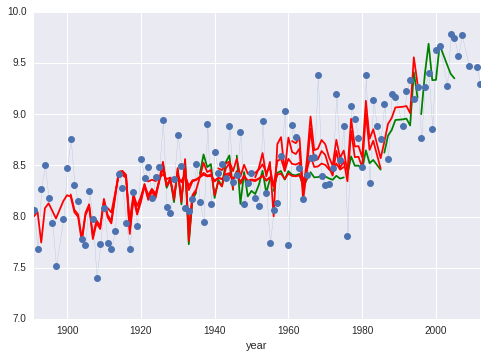

In [166]:
#Experimento 2.0
#Elegir representantes caracteristicos de cada clima (porque dicho clima representa la mayor parte del pais)
#Ademas el pais intenta ser lo mas grande posible dentro del clima elegido. 

# Levanto los datos de cada pais, las mediciones son por mes
# Como los años que no aparecen son los mismos para todos, yo tomaría a partir de 1891, que están todos
# Canada:

df_countries = pd.read_csv('./data/paises/Canada.csv',' ',header = None, names = ['year', 'Canada'])
df_countries['year'] = df_countries['year'].map(lambda x: int(math.modf(x)[1]))

# (Notar que este bucle vuelve a levantar Canada.csv)
# Repito para el resto
for filename in os.listdir('./data/paises/'):
    if os.path.isfile('./data/paises/' + filename) and filename != 'Canada.csv':
        aux = pd.read_csv('./data/paises/'+filename,' ',header = None, names = ['year', 'temp'])
        aux['year'] = aux['year'].map(lambda x: int(math.modf(x)[1]))
        filename = filename[:len(filename) - 5]
        df_countries[filename] = aux.temp

# Calculo el promedio anual de cada país
df = df_countries.groupby('year').mean().reset_index()

# Como los datos son consecutivos desde 1891, me quedo con ese subconjunto
df = (df[df['year'].isin(range(1891,2013))]).reset_index()

# Agrego la temperatura del planeta
df_world = pd.read_csv('./data/worldTemperature.csv', ' ', header = None, names = ['x', 'y'])
df_world = (df_world[df_world['x'].isin(range(1891,2013))]).reset_index()
df['world'] = df_world.y
mascara = mascara_outliers(df['world'])
df = df[mascara]

#Ahora aplico CM y grafico:
# Segundo parámetro: cant. de países en el dataframe

#Varios casos de entrenamiento
er_train = []
er_pred = []

for year in range(1926,2001,10):
    ECM = predecir(year,10)
    print(ECM)
    er_train.append(ECM[0])
    er_pred.append(ECM[1])


print("Error promedio de entrenamiento: {:.3f}".format(np.array(er_train).mean()))
print("Error promedio de prediccion: {:.3f}".format(np.array(er_pred).mean()))
sns.tsplot(time=df['year'], data=df['world'], interpolate=False)
sns.plt.xlim((1891, 2012))
sns.plt.show()

#Elegir dos intervalos (mejor/peor?) y plotear para mostrar en el informe

#Fin expermiento 2.0

Zambia.csv
Paraguay.csv
Colombia.csv
Ukraine.csv
Germany.csv
Mongolia.csv
Egypt.csv
Greenland.csv
Italy.csv
[0.16618811667423969, 0.11819064611200943]
[0.22038102126699649, 0.076299031452718255]
[0.21651253353622879, 0.13408173911312274]
[0.28385502589112083, 0.15926457545880029]
[0.35284544317396938, 0.18476624602495489]
[0.43188382634390221, 0.19897707848573495]
[0.41852848601083681, 0.068164940380179867]
[0.25356598771127131, 0.11088504196950974]
Error promedio de entrenamiento: 0.293
Error promedio de prediccion: 0.131


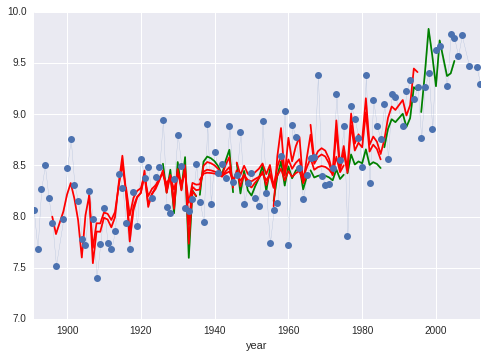

In [167]:
#Experimento 2.1


def armar_matriz_A_multivar_2(s,w):
    temp = []
    for t in s:
        temp.append([np.average(t, weights=w),1])
    return np.array(temp)


def entrenar_y_predecir_en_rangos(df, rango_entrenamiento, rango_prediccion, w, paises):
    regr = linear_model.LinearRegression(fit_intercept=False)
    ECM = []
    # Entreno el modelo
    df_e = df[df['year'].isin(rango_entrenamiento)]
    df_aux = df_e.ix[:,2:paises + 2]
    
    A_e = armar_matriz_A_multivar_2(df_aux.values,w)
    regr.fit(A_e, df_e['world'])

    # Me fijo la aproximacion que se realizo
    df_e['p'] = regr.predict(A_e)
    sns.tsplot(time=df_e['year'], data=df_e['p'], color='r')
    
    ECM.append(sum((df_e['p']-df_e['world'])**2)/len(rango_prediccion))
    
    # Realizo predicciones
    df_p = df[df['year'].isin(rango_prediccion)]
    df_aux = df_p.ix[:,2:paises + 2]
    A_p = armar_matriz_A_multivar_2(df_aux.values,w)
    df_p['p'] = regr.predict(A_p)
    sns.tsplot(time=df_p['year'], data=df_p['p'], color='g')

    ECM.append(sum((df_p['p']-df_p['world'])**2)/len(rango_prediccion))
    return ECM

def predecir(k, paises,w):
    return entrenar_y_predecir_en_rangos(df, range(k-30,k), range(k,k+10), w, paises)



#Utilizando promedio pesado segun importancia del clima
#Levanto los datos de cada pais, las mediciones son por mes
    
# Canada:
df_countries = pd.read_csv('./data/paises/Canada.csv',' ',header = None, names = ['year', 'Canada'])
df_countries['year'] = df_countries['year'].map(lambda x: int(math.modf(x)[1]))

# Repito para el resto
for filename in os.listdir('./data/paises/'):
    if os.path.isfile('./data/paises/' + filename) and filename != 'Canada.csv':
        print (filename)
        aux = pd.read_csv('./data/paises/'+filename,' ',header = None, names = ['year', 'temp'])
        aux['year'] = aux['year'].map(lambda x: int(math.modf(x)[1]))
        filename = filename[:len(filename) - 5]
        df_countries[filename] = aux.temp

# Calculo el promedio anual de cada país
df = df_countries.groupby('year').mean().reset_index()

# Como los datos son consecutivos desde 1891, me quedo con ese subconjunto
df = (df[df['year'].isin(range(1891,2013))]).reset_index()

# Agrego la temperatura del planeta
df_world = pd.read_csv('./data/worldTemperature.csv', ' ', header = None, names = ['x', 'y'])
df_world = (df_world[df_world['x'].isin(range(1891,2013))]).reset_index()
df['world'] = df_world.y
mascara = mascara_outliers(df['world'])
df = df[mascara]

#Ahora aplico CM y grafico:
# Segundo parámetro: cant. de países en el dataframe
#Tercer parametro w: pesos por paises

#Ahora aplico CM y grafico:
# Segundo parámetro: cant. de países en el dataframe

#Varios casos de entrenamiento
er_train = []
er_pred = []

w= [0.18,0.095,0.09,0.1,0.08,0.02,0.16,0.16,0.1,0.02]

for year in range(1926,2001,10):
    ECM = predecir(year,10,w)
    print(ECM)
    er_train.append(ECM[0])
    er_pred.append(ECM[1])


print("Error promedio de entrenamiento: {:.3f}".format(np.array(er_train).mean()))
print("Error promedio de prediccion: {:.3f}".format(np.array(er_pred).mean()))
sns.tsplot(time=df['year'], data=df['world'], interpolate=False)
sns.plt.xlim((1891, 2012))
sns.plt.show()

#Elegir dos intervalos (mejor/peor?) y plotear para mostrar en el informe

#Fin expermiento 2.1



[0.20453833247631334, 0.089219748595094822]
[0.23818693915602512, 0.15921640187201691]
[0.29668168388973842, 0.099315222136518513]
[0.26790827734761136, 0.19866828409301687]
[0.39575567456888117, 0.12237357604287377]
[0.40841124496175063, 0.15368748853246436]
[0.47165060666336062, 0.14205049018598132]
[0.42498968820597494, 0.59512996303347976]
Error promedio de entrenamiento: 0.339
Error promedio de prediccion: 0.195


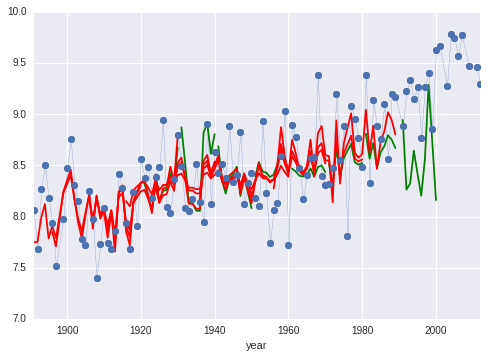

In [176]:
#Experimento 2.2 (ejecutarlo sin compilar la celda anterior para que no tire error con la funcion predecir. Hacerlo con la IN[175])
#Elegir varios representantes de cada clima y promediarlos obteniendo la tempertaura promedio anual de un clima dado.
# Se divide en 3 regiones: Low Latitude, Mid Latitude, High Latitude; que a la vez se subdivide en tres grupos
# Se tienen hasta 9 representantes por cada grupo, hasta 3 por cada subgrupo
# Low Latitude comprende más region, si lo hacemos pesado, debería ser el que tiene más peso

# Inicializo un dataframe para cada region
df_lowLat = pd.read_csv('./data/paises/lowLat/Brazil.csv', ' ',header = None, names = ['year', 'Brazil'])
df_lowLat['year'] = df_lowLat['year'].map(lambda x: int(math.modf(x)[1]))

df_midLat = pd.read_csv('./data/paises/midLat/China.csv', ' ',header = None, names = ['year', 'China'])
df_midLat['year'] = df_midLat['year'].map(lambda x: int(math.modf(x)[1]))

df_highLat = pd.read_csv('./data/paises/highLat/Canada.csv', ' ',header = None, names = ['year', 'Canada'])
df_highLat['year'] = df_highLat['year'].map(lambda x: int(math.modf(x)[1]))

regions = ['lowLat', 'midLat', 'highLat']

for region in regions:
    for filename in os.listdir('./data/paises/' + region + '/'):
        if region == 'lowLat' and filename != 'Brazil.csv':
            aux = pd.read_csv('./data/paises/' + region + '/' + filename, ' ', header = None, names = ['year', 'temp'])
            aux['year'] = aux['year'].map(lambda x: int(math.modf(x)[1]))
            filename = filename[:len(filename) - 5]
            df_lowLat[filename] = aux.temp
        elif region == 'midLat' and filename != 'China.csv':
            aux = pd.read_csv('./data/paises/' + region + '/' + filename, ' ', header = None, names = ['year', 'temp'])
            aux['year'] = aux['year'].map(lambda x: int(math.modf(x)[1]))
            filename = filename[:len(filename) - 5]
            df_midLat[filename] = aux.temp
        elif region == 'highLat' and filename != 'Canada.csv':
            aux = pd.read_csv('./data/paises/' + region + '/' + filename, ' ', header = None, names = ['year', 'temp'])
            aux['year'] = aux['year'].map(lambda x: int(math.modf(x)[1]))
            filename = filename[:len(filename) - 5]
            df_highLat[filename] = aux.temp

# Calculo el promedio anual de los países de cada región
df_lowLat  = df_lowLat.groupby('year').mean()
df_midLat  = df_midLat.groupby('year').mean()
df_highLat = df_highLat.groupby('year').mean()

# Obtengo el promedio anual de cada region
df_lowLat['lowLat']   = df_lowLat.mean(axis = 1)
df_midLat['midLat']   = df_midLat.mean(axis = 1)
df_highLat['highLat'] = df_highLat.mean(axis = 1)

# Necesario para que los años sean una key, y así poder manipularlos mejor (para plotear, por ej)
df_lowLat   = df_lowLat.reset_index() 
df_midLat   = df_midLat.reset_index()
df_highLat  = df_highLat.reset_index()
# Acomodo los rangos
# En df voy a juntar todo
df         = (df_lowLat[df_lowLat['year'].isin(range(1891,2013))]).reset_index()
df_midLat  = (df_midLat[df_midLat['year'].isin(range(1891,2013))]).reset_index()
df_highLat = (df_highLat[df_highLat['year'].isin(range(1891,2013))]).reset_index()

# uno los dataframes
df['midLat']  = df_midLat.midLat
df['highLat'] = df_highLat.highLat

# Agrego la temperatura del planeta
df_world = pd.read_csv('./data/worldTemperature.csv', ' ', header = None, names = ['x', 'y'])
df_world = (df_world[df_world['x'].isin(range(1891,2013))]).reset_index()
df['world'] = df_world.y
mascara = mascara_outliers(df['world'])
df = df[mascara]
# Y me quedo con lo que me importa
# (Me guardo la columna index para que sea retrocompatible con el método predecir)
df = df[['index', 'year', 'lowLat', 'midLat', 'highLat', 'world']]

#Ahora aplico CM y grafico:
# Segundo parámetro: cant. de países en el dataframe


#Varios casos de entrenamiento
er_train = []
er_pred = []

for year in range(1921,2001,10):
    ECM = predecir(year,3)
    print(ECM)
    er_train.append(ECM[0])
    er_pred.append(ECM[1])


print("Error promedio de entrenamiento: {:.3f}".format(np.array(er_train).mean()))
print("Error promedio de prediccion: {:.3f}".format(np.array(er_pred).mean()))
sns.tsplot(time=df['year'], data=df['world'], interpolate=False)
sns.plt.xlim((1891, 2012))
sns.plt.show()

#Elegir dos intervalos (mejor/peor?) y plotear para mostrar en el informe

#Fin experimento 2.2


In [383]:
#Experimento 3': Predecir la altura sobre el nivel del mar a partir de las temperaturas del planeta
#Esto no estaria funcionando como lo esperado. La idea era en funcion de la temperatura, pero termino siendo del año...
#No encontre funciones que utilicen solo la temperatura y den algo razonable :()



def entrenar_y_predecir_en_rangos(df, rango_entrenamiento, rango_prediccion):
    regr = linear_model.LinearRegression(fit_intercept=False)
    ECM = []
    # Entreno el modelo
    df_e = df[df['year'].isin(rango_entrenamiento)]
    df_aux = df_e.ix[:,0:2]
    A_e = armar_matriz_A(df_aux.values)
    regr.fit(A_e, df_e['gmsl'])

    # Me fijo la aproximacion que se realizo
    df_e['p'] = regr.predict(A_e)
    sns.tsplot(time=df_e['year'], data=df_e['p'], color='r')
    
    ECM.append(math.sqrt(sum((df_e['p']-df_e['gmsl'])**2)/len(rango_prediccion)))
    # Realizo predicciones
    df_p = df[df['year'].isin(rango_prediccion)]
    df_aux = df_p.ix[:,0:2]
    A_p = armar_matriz_A(df_aux.values)
    df_p['p'] = regr.predict(A_p)
    sns.tsplot(time=df_p['year'], data=df_p['p'], color='g')

    ECM.append(math.sqrt(sum((df_p['p']-df_p['gmsl'])**2)/len(rango_prediccion)))
    return ECM

def entrenar_y_pronosticar(df, rango_entrenamiento, rango_prediccion):
    regr = linear_model.LinearRegression(fit_intercept=False)
    ECM = []
    # Entreno el modelo
    df_e = df[df['year'].isin(rango_entrenamiento)]
    A_e = armar_matriz_A(df_e['world'])
    regr.fit(A_e, df_e['gmsl'])

    # Me fijo la aproximacion que se realizo
    df_e['p'] = regr.predict(A_e)
    sns.tsplot(time=df_e['year'], data=df_e['p'], color='r')
    
    # Realizo predicciones

    A_p = armar_matriz_A(rango_prediccion)
    df_p = regr.predict(A_p)
    sns.tsplot(time=rango_prediccion, data=df_p, color='g')

    return 

def predecir(k):
    return entrenar_y_predecir_en_rangos(df, range(k-40,k), range(k,k+30))

def pronosticar(k):
    return entrenar_y_pronosticar(df, range(k-35,k), range(k,k+10))


def armar_matriz_A(s):
    temp = []
    for t in s:
        temp.append([t[1]**2,t[0]**4,t[0]**2,1])
    return np.array(temp)


[6.575683565507874, 10.26414332439864]
[5.944846320729948, 7.425332802535157]
[6.499930002254778, 10.677471930109366]
[5.942593810644197, 18.557729891783186]
[5.37492758965581, 20.69528238747492]
[5.7235621308274895, 16.86904925458054]
[6.293560061106658, 15.190133456940794]
[7.244112327476581, 9.269659325310204]
[5.628595416587666, 7.755994958256766]
[4.959591068216243, 13.582625801890872]
[5.910868250594147, 6.970843216418554]
[6.120777079379122, 5.652668578417592]
[5.922450831802314, 8.896102429971673]
Error promedio de entrenamiento: 6.011
Error promedio de prediccion: 11.677


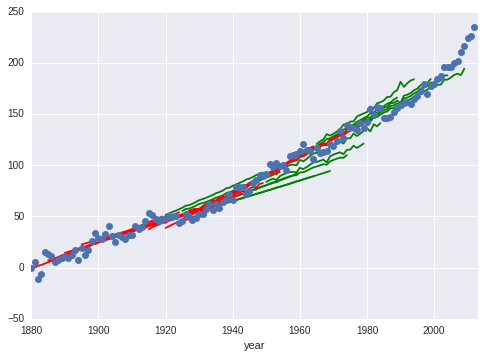

,year,temp,gmsl
0,1880,0.00,0.0
1,1881,0.40,5.6
2,1882,0.70,-11.2
3,1883,0.15,-5.9
4,1884,-0.19,15.0
5,1885,0.37,13.5
6,1886,-0.12,11.1
7,1887,0.44,5.5
8,1888,-0.05,7.6
9,1889,0.85,9.2


In [385]:
# Inicializo un dataframe con GMSL
df_gmsl = pd.read_csv('./data/CSIRO_Recons_gmsl_yr_2015.csv',header = None,names =['year', 'gmsl','unc'])
df_gmsl = df_gmsl[['year','gmsl']]
#Transformo los años a enteros,cambio la referencia a 1880 y los tomo en el rango adecuado
df_gmsl['year'] = df_gmsl['year'].map(lambda x: int(math.modf(x)[1]))
df_gmsl['gmsl'] = df_gmsl['gmsl'].map(lambda x: x+158.7)
df_gmsl = df_gmsl[df_gmsl['year'].isin(range(1880,2013))]

#Cargo el df del mundo
df = pd.read_csv('./data/worldTemperature.csv', ' ', header = None, names = (['year', 'temp']))

#Tomo las temperaturas relativas a 1880
df['temp'] = df['temp'].map(lambda x: x-7.79)
df['gmsl'] = df_gmsl['gmsl']


#Veo correlacion entre las variables
corr = df.corr(method='pearson', min_periods=1)
#print(corr)



#Varios casos de entrenamiento
er_train = []
er_pred = []

for year in range(1920,1985,5):
    ECM = predecir(year)
    print(ECM)
    er_train.append(ECM[0])
    er_pred.append(ECM[1])


print("Error promedio de entrenamiento: {:.3f}".format(np.array(er_train).mean()))
print("Error promedio de prediccion: {:.3f}".format(np.array(er_pred).mean()))
sns.tsplot(time=df_gmsl['year'], data=df_gmsl['gmsl'], interpolate=False)
sns.plt.xlim((1880, 2013))
sns.plt.show()
df

